In [47]:
import numpy as np
import scipy as scp
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

#Keras Imports
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Layer, Activation, Flatten, BatchNormalization
from keras.models import Sequential, Model,load_model
from tensorflow.keras import activations

import os
import sys


#Utility
# from utils import binarize
sys.path.insert(0, '..')
from binarization_utils import *
# from model_architectures import get_model

#Probability
import tensorflow_probability as tfp


from keras.models import Model
from tensorflow.keras.layers import Input

In [48]:
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


In [49]:
training=True
dataset='CIFAR-10'
# Train=True
# Evaluate=False

batch_norm_eps=1e-4
batch_norm_alpha=0.1

# for loading SVHN dataset
def load_svhn(path_to_dataset):
	import scipy.io as sio
	train=sio.loadmat(path_to_dataset+'/train.mat')
	test=sio.loadmat(path_to_dataset+'/test.mat')
	extra=sio.loadmat(path_to_dataset+'/extra.mat')
	X_train=np.transpose(train['X'],[3,0,1,2])
	y_train=train['y']-1

	X_test=np.transpose(test['X'],[3,0,1,2])
	y_test=test['y']-1

	X_extra=np.transpose(extra['X'],[3,0,1,2])
	y_extra=extra['y']-1

	X_train=np.concatenate((X_train,X_extra),axis=0)
	y_train=np.concatenate((y_train,y_extra),axis=0)

	return (X_train,y_train),(X_test,y_test)

In [50]:
if dataset=="MNIST":
	(X_train, y_train), (X_test, y_test) = mnist.load_data()
	# convert class vectors to binary class matrices
	X_train = X_train.reshape(-1,784)
	X_test = X_test.reshape(-1,784)
	use_generator=False
elif dataset=="CIFAR-10":
	use_generator=True
	(X_train, y_train), (X_test, y_test) = cifar10.load_data()
elif dataset=="SVHN":
	use_generator=True
	(X_train, y_train), (X_test, y_test) = load_svhn('svhn_data')
else:
	raise("dataset should be one of the following: [MNIST, CIFAR-10, SVHN].")

    
#Restructure Data
X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
# Y_train = to_categorical(y_train, 10)
# Y_test = to_categorical(y_test, 10)
X_train /= 255
X_test /= 255
X_train=2*X_train-1
X_test=2*X_test-1


#Train Val Split
X_train,X_val,y_train, y_val = train_test_split(X_train,y_train,test_size = 0.10)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(y_train.shape[0], 'train samples')

print(X_val.shape[0], 'val samples')
print(y_val.shape[0], 'val samples')

print(X_test.shape[0], 'test samples')
print(y_test.shape[0], 'test samples')


X_train shape: (45000, 32, 32, 3)
45000 train samples
45000 train samples
5000 val samples
5000 val samples
10000 test samples
10000 test samples


In [51]:
class Sign_layer(Layer):
    def __init__(self, levels=1,**kwargs):
        self.levels=levels
        super(Sign_layer, self).__init__(**kwargs)
    def build(self, input_shape):
        ars=np.arange(self.levels)+1.0
        ars=ars[::-1]
        means=ars/np.sum(ars)
        self.means=[K.variable(m) for m in means]
        self._trainable_weights = self.means
        
    def call(self, x, mask=None):
        resid = x
        out_bin=0
        for l in range(self.levels):
            out=binarize(resid)*(K.abs(self.means[l]))
#             print(out)
            out_bin=out_bin+out
            resid=resid-out
        return out_bin
    
        # the following lines were an idea to implement flips using tensor operations
        '''positive_mask = tf.cast(out_bin > 0, tf.float32)
        negative_mask = tf.cast(out_bin < 0, tf.float32)
        
        positive_flips = tf.random.uniform(out_bin.shape) < p[1]
        positives = tf.math.multiply(positive_mask, (tf.cast(tf.random.uniform(out_bin.shape) < p[1], tf.float32) - 1))
        negatives = tf.math.multiply(negative_mask, (tf.cast(tf.random.uniform(out_bin.shape) < p[0], tf.float32) - 1))
        return'''

    def get_output_shape_for(self,input_shape):
        return input_shape
    def compute_output_shape(self,input_shape):
        return input_shape
    def set_means(self,X):
        means=np.zeros((self.levels))
        means[0]=1
        resid=np.clip(X,-1,1)
        approx=0
        for l in range(self.levels):
            m=np.mean(np.absolute(resid))
            out=np.sign(resid)*m
            approx=approx+out
            resid=resid-out
            means[l]=m
            err=np.mean((approx-np.clip(X,-1,1))**2)

        means=means/np.sum(means)
        sess=K.get_session()
        sess.run(self.means.assign(means))
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'levels': self.levels
        })
        return config
    
class binary_dense_error_var(Layer):
    def __init__(self,n_in,n_out,error_type,error_dict,**kwargs):
        self.n_in=n_in
        self.n_out=n_out
        self.error_type=error_type
        self.error_dict= error_dict
        assert self.error_type in ["NoError", "Flip","InnerDot"], "error_type of {0} is invalid".format(error_type)
        super(binary_dense_error_var,self).__init__(**kwargs)
        
        if(error_type == "InnerDot"):
            max_pop = self.n_in
            self.uh = self.error_dict["uh"]
            self.ul = self.error_dict["ul"]
            self.sigl = self.error_dict["sigl"]
            self.sigh = self.error_dict["sigh"]

            #Not Used, Mainly used for information
            means = [m * self.ul + (max_pop - m) * self.uh for m in range(0, max_pop+1)]
            stdvs = [np.sqrt(m * (self.sigl**2) + (max_pop - m)*(self.sigh**2)) for m in range(0, max_pop+1)]
            self.distributions = [tfp.distributions.Normal(loc= m, scale = sig) for m,sig in zip(means,stdvs)]
    
        elif(error_type == "Flip"):
            self.p = self.error_dict["p"]
            
    def build(self, input_shape):
        stdv=1/np.sqrt(self.n_in)
        w = np.random.normal(loc=0.0, scale=stdv,size=[self.n_in,self.n_out]).astype(np.float32)
        self.w=K.variable(w)
        self.gamma_w=K.variable(1.0)
        self._trainable_weights=[self.w,self.gamma_w]
        
        
#         if(error_type == "InnerDot"):
#             max_pop = self.n_in+1
#             self.uh = self.error_dict["uh"]
#             self.ul = self.error_dict["ul"]
#             self.sigl = self.error_dict["sigl"]
#             self.sigh = self.error_dict["sigh"]

#             means = [m * ul + (max_pop - 1 - m) * uh for m in range(0, max_pop+1)]
#             stdvs = [np.sqrt(m * (sigl**2) + (max_pop - 1 - m)*(sigh**2)) for m in range(0, max_pop+1)]
#             self.distributions = [tfp.distributions.Normal(loc= m, scale = sig) for m,sig in zip(means,stdvs)]
            
    def call(self, x,training=None):
        
        #Designed with Batch norm in mind, Binarization done after. 
        if(self.error_type == "NoError"):
            self.clamped_w=binarize(self.w)
            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
            self.out = self.prod
            
            self.w = K.clip(self.w, -1.0, 1.0)
            self.gamma_w = K.clip(self.w, -1.0, 1.0)
            return self.out
        elif(self.error_type == "Flip"):
            self.clamped_w=binarize(self.w)*((2*tf.cast(tf.random.uniform(self.w.shape) > self.p, tf.float32)) - 1)
            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
            self.out = self.prod
            
            self.w = K.clip(self.w, -1.0, 1.0)
            self.gamma_w = K.clip(self.w, -1.0, 1.0)
            return self.out
        elif(self.error_type == "InnerDot"):
            
            if training:
                
                #Perfrom error model on inference
                #No Error Model first
                self.clamped_w=binarize(self.w)
                
                self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
                
                # Make Model
                self.clamped_x=binarize(x)
                gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
                #self.prod = K.dot(x,self.clamped_w)
                self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2

                #Add Error 
                self.dist = tfp.distributions.Normal(loc = self.pop * self.ul + (self.n_in - self.pop) * self.uh,
                                                     scale= tf.math.sqrt(self.pop * (self.sigl**2) + (self.n_in - self.pop)*(self.sigh**2)))
                
                self.samps = self.dist.sample(1)
                self.samps = tf.squeeze(self.samps, axis = 0)
        
                #Use Histogram for binning
                self.step = self.ul - self.uh
                self.edges = np.arange(self.n_in*self.uh-self.step/2, self.n_in*self.ul+self.step, self.step,dtype=np.float32)
                self.bins= tfp.stats.find_bins(self.samps, self.edges, extend_lower_interval = True, extend_upper_interval=True)
                self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.n_in)
                
                
                #Gradient not using binning
                return  self.prod + K.stop_gradient(self.out -  self.prod)

            else:
                #Perfrom error model on inference
                #No Error Model first
                self.clamped_w=binarize(self.w)
                self.clamped_x=binarize(x)
                gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
                #self.prod = K.dot(x,self.clamped_w)
                self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2

                #Add Error 
                self.dist = tfp.distributions.Normal(loc = self.pop * self.ul + (self.n_in - self.pop) * self.uh,
                                                     scale= tf.math.sqrt(self.pop * (self.sigl**2) + (self.n_in - self.pop)*(self.sigh**2)))
                

                self.samps = self.dist.sample(1)
                self.samps = tf.squeeze(self.samps, axis = 0)
        
                #Use Histogram for binning
                self.step = self.ul - self.uh
                self.edges = np.arange(self.n_in*self.uh-self.step/2, self.n_in*self.ul+self.step, self.step,dtype=np.float32)
                self.bins= tfp.stats.find_bins(self.samps, self.edges, extend_lower_interval = True, extend_upper_interval=True)
                self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.n_in)
                
                self.w = K.clip(self.w, -1.0, 1.0)
                self.gamma_w = K.clip(self.w, -1.0, 1.0)       
                return self.out
        
        
    
    def get_output_shape_for(self,input_shape):
        return (self.n_in, self.n_out)
    
    
    def compute_output_shape(self,input_shape):
        return (self.n_in, self.n_out)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_in': self.n_in,
            'n_out': self.n_out,
            'error_type': self.error_type,
            'error_dict': self.error_dict
        })
        return config

    

In [52]:
class conv_batchnorm_sign(Layer):
    def __init__(self,nfilters,ch_in,k,padding,error_type,error_dict,strides=(1,1),batch_norm_params={"eps" : 1e-4, "alpha" : 0.1},reg_params={"type" : None, "b" : 32, "lambda" : 0.0001, "alpha" : 1},**kwargs):
        self.nfilters=nfilters
        self.ch_in=ch_in
        self.k=k
        self.padding=padding
        self.strides=strides
        self.error_type=error_type
        self.error_dict= error_dict
        self.batch_norm_eps = batch_norm_params["eps"]
        self.batch_norm_alpha = batch_norm_params["alpha"]
        
        # regularization hyperparameters
        self.loss_type = reg_params["type"]
        # desired bit error tolerance
        self.b = reg_params["b"]
        self.reg_lambda = reg_params["lambda"]
        self.alpha = reg_params["alpha"]
        
        assert self.error_type in ["NoError", "Flip","InnerDot"], "error_type of {0} is invalid".format(error_type)
        

        super(conv_batchnorm_sign,self).__init__(**kwargs)
        
        if(error_type == "InnerDot"):
            self.uh = self.error_dict["uh"]
            self.ul = self.error_dict["ul"]
            self.sigl = self.error_dict["sigl"]
            self.sigh = self.error_dict["sigh"]

#             #Not Used, Mainly used for information
#             means = [m * self.ul + (max_pop - m) * self.uh for m in range(0, max_pop+1)]
#             stdvs = [np.sqrt(m * (self.sigl**2) + (max_pop - m)*(self.sigh**2)) for m in range(0, max_pop+1)]
#             self.distributions = [tfp.distributions.Normal(loc= m, scale = sig) for m,sig in zip(means,stdvs)]
    
        elif(error_type == "Flip"):
            self.p = self.error_dict["p"]

    def build(self, input_shape):
        stdv=1/np.sqrt(self.k*self.k*self.ch_in)
        w = np.random.normal(loc=0.0, scale=stdv,size=[self.k,self.k,self.ch_in,self.nfilters]).astype(np.float32)
        if tensorflow.keras.backend.backend()=="mxnet":
            w=w.transpose(3,2,0,1)
        self.w=K.variable(w)
        self.gamma_w=K.variable(1.0)
#         self._trainable_weights=[self.w,self.gamma_w]
        
        self.max_pop = self.k*self.k*self.ch_in

        
        # batchnorm and sign activation
        self.batchnorm_layer = BatchNormalization(axis=-1, momentum=self.batch_norm_alpha, epsilon=self.batch_norm_eps)
        self.sign_layer = Sign_layer(levels=1)
        
#         self.batchnorm_layer.build(input_shape=(None, input_shape[1]-(self.k-1), input_shape[2]-(self.k-1), self.nfilters))
#         self.sign_layer.build(input_shape)

        self._trainable_weights=[self.w, self.gamma_w] + self.batchnorm_layer._trainable_weights + self.sign_layer._trainable_weights

    def call(self, x,mask=None, training=None):
        
        if(self.error_type == "NoError"):
            constraint_gamma=K.abs(self.gamma_w)#K.clip(self.gamma_w,0.01,10)
            self.clamped_w=constraint_gamma*binarize(self.w)
            self.out=K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides )
            self.output_dim=self.out.get_shape().as_list()
#             self.clamped_w=binarize(self.w)
#             self.prod=K.abs(self.gamma_w)*K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides )
#             self.clamped_x=binarize(x)
#             gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
#             self.pop = (K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides)+self.max_pop)/2
#             self.step = self.ul - self.uh
#             self.edges = np.arange(self.max_pop*self.uh-self.step/2, self.max_pop*self.ul+self.step, self.step,dtype=np.float32)
#             self.bins= tfp.stats.find_bins(self.pop * self.ul + (self.max_pop - self.pop) * self.uh, self.edges, extend_lower_interval = True, extend_upper_interval=True)
#             self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.max_pop)
#             self.out = self.prod + K.stop_gradient(self.out -  self.prod)
        elif(self.error_type == "Flip"):
            constraint_gamma=K.abs(self.gamma_w)#K.clip(self.gamma,0.01,10)
            self.clamped_w=constraint_gamma*binarize(self.w)*((2*tf.cast(tf.random.uniform(self.w.shape) > self.p, tf.float32)) - 1)
            self.out=K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides )
            self.output_dim=self.out.get_shape().as_list() 

        elif(self.error_type == "InnerDot"):
            


            #Perfrom error model on inference
            #No Error Model first
            self.clamped_w=binarize(self.w)

            #self.prod=K.abs(self.gamma_w)*K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides )
            self.prod=K.abs(self.gamma_w)*K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides )

            # Make Model
            self.clamped_x=binarize(x)
            gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
            #self.prod = K.dot(x,self.clamped_w)
            #self.pop = (K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides)+self.max_pop)/2
            self.pop = (K.conv2d(x, kernel=self.clamped_w, padding=self.padding,strides=self.strides)+self.max_pop)/2

            #Add Error 
            self.dist = tfp.distributions.Normal(loc = self.pop * self.ul + (self.max_pop - self.pop) * self.uh,
                                                 scale= tf.math.sqrt(self.pop * (self.sigl**2) + (self.max_pop - self.pop)*(self.sigh**2)))

            self.samps = self.dist.sample(1)
            self.samps = tf.squeeze(self.samps, axis = 0)                

            #Use Histogram for binning
            self.step = self.ul - self.uh
            self.edges = np.arange(self.max_pop*self.uh-self.step/2, self.max_pop*self.ul+self.step, self.step,dtype=np.float32)
            self.bins= tfp.stats.find_bins(self.samps, self.edges, extend_lower_interval = True, extend_upper_interval=True)
            self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.max_pop)
            
            self.out = self.prod + K.stop_gradient(self.out -  self.prod)

        # regulariztion
        if training:
            

            # regularization
            # threshold regularization
            batchlayer = self.batchnorm_layer
            gamma = batchlayer.gamma
            beta = batchlayer.beta
            # redo batchnorm calculation
            input_shape = self.out.shape
            ndims = len(input_shape)
            reduction_axes = [i for i in range(ndims) if i not in batchlayer.axis]
            keep_dims = batchlayer.virtual_batch_size is not None or len(batchlayer.axis) > 1
            mean, var = batchlayer._moments(tf.cast(self.out, batchlayer._param_dtype),reduction_axes,keep_dims=keep_dims)
            T = mean - tf.math.divide(tf.math.sqrt(var),gamma)*beta
#             tf.print(tf.math.is_nan(T), output_stream=sys.stdout)
#             tf.print(gamma, output_stream=sys.stdout)

            
            if self.loss_type == "uniform":
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.b - tf.math.abs(self.out - T))))
            elif self.loss_type == "exp":
                self.add_loss(self.reg_lambda*tf.reduce_mean(-1*tf.math.exp(self.alpha*(2*T - self.max_pop))*tf.math.abs(self.out - T)))
#                 self.add_loss(self.reg_lambda*tf.reduce_mean(-1*tf.math.exp(self.alpha*(T + self.max_pop))*tf.math.abs(self.out - T)))
            elif self.loss_type == "inverse":
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.math.reciprocal(2*T - self.max_pop)*(self.b - tf.math.abs(self.out - T))))
            elif self.loss_type == "b=inv_Tmaxpop":
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.alpha*tf.math.reciprocal((T+self.max_pop)*self.max_pop) - tf.math.abs(self.out - T))))    
                
        self.out = self.batchnorm_layer(self.out)
        self.out = self.sign_layer(self.out)
        
#         self.w = K.clip(self.w, -1.0, 1.0)
#         self.gamma_w = K.clip(self.w, -1.0, 1.0) 
        return self.out
        
    def  get_output_shape_for(self,input_shape):
        return (input_shape[0], self.output_dim[1],self.output_dim[2],self.output_dim[3])
    def compute_output_shape(self,input_shape):
        return (input_shape[0], self.output_dim[1],self.output_dim[2],self.output_dim[3])
    
class dense_batchnorm_sign(Layer):
    def __init__(self,n_in,n_out,error_type,error_dict,batch_norm_params={"eps" : 1e-4, "alpha" : 0.1},reg_params={"type" : None, "b" : 32, "lambda" : 0.0001, "alpha" : 1},**kwargs):
        self.n_in=n_in
        self.n_out=n_out
        self.error_type=error_type
        self.error_dict= error_dict
        self.batch_norm_eps = batch_norm_params["eps"]
        self.batch_norm_alpha = batch_norm_params["alpha"]
        
        # regularization hyperparameters
        self.loss_type = reg_params["type"]
        # desired bit error tolerance
        self.b = reg_params["b"]
        self.reg_lambda = reg_params["lambda"]
        self.alpha = reg_params["alpha"]
        
        assert self.error_type in ["NoError", "Flip","InnerDot"], "error_type of {0} is invalid".format(error_type)
        super(dense_batchnorm_sign,self).__init__(**kwargs)
        
        self.max_pop = self.n_in
        if(error_type == "InnerDot"):
            max_pop = self.n_in
            self.uh = self.error_dict["uh"]
            self.ul = self.error_dict["ul"]
            self.sigl = self.error_dict["sigl"]
            self.sigh = self.error_dict["sigh"]

#             #Not Used, Mainly used for information
#             means = [m * self.ul + (max_pop - m) * self.uh for m in range(0, max_pop+1)]
#             stdvs = [np.sqrt(m * (self.sigl**2) + (max_pop - m)*(self.sigh**2)) for m in range(0, max_pop+1)]
#             self.distributions = [tfp.distributions.Normal(loc= m, scale = sig) for m,sig in zip(means,stdvs)]
    
        elif(error_type == "Flip"):
            self.p = self.error_dict["p"]
            
    def build(self, input_shape):
        stdv=1/np.sqrt(self.n_in)
        w = np.random.normal(loc=0.0, scale=stdv,size=[self.n_in,self.n_out]).astype(np.float32)
        self.w=K.variable(w)
        self.gamma_w=K.variable(1.0)
        
        # batchnorm and sign activation
        self.batchnorm_layer = BatchNormalization(axis=-1, momentum=self.batch_norm_alpha, epsilon=self.batch_norm_eps)
        self.sign_layer = Sign_layer(levels=1)
        
#         self._trainable_weights=[self.w,self.gamma_w] + self.batchnorm_layer._trainable_weights + self.sign_layer._trainable_weights
        
        
#         if(error_type == "InnerDot"):
#             max_pop = self.n_in+1
#             self.uh = self.error_dict["uh"]
#             self.ul = self.error_dict["ul"]
#             self.sigl = self.error_dict["sigl"]
#             self.sigh = self.error_dict["sigh"]

#             means = [m * ul + (max_pop - 1 - m) * uh for m in range(0, max_pop+1)]
#             stdvs = [np.sqrt(m * (sigl**2) + (max_pop - 1 - m)*(sigh**2)) for m in range(0, max_pop+1)]
#             self.distributions = [tfp.distributions.Normal(loc= m, scale = sig) for m,sig in zip(means,stdvs)]
            
    def call(self, x,training=None):
        
        #Designed with Batch norm in mind, Binarization done after. 
        if(self.error_type == "NoError"):
            self.clamped_w=binarize(self.w)
            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
            self.out = self.prod

#             self.clamped_w=binarize(self.w)
#             self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
#             self.clamped_x=binarize(x)
#             gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
#             self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2
#             self.out = K.abs(self.gamma_w)*gamma_x*(2*(self.pop * self.ul + (self.n_in - self.pop) * self.uh)-self.n_in)         
#             self.out = self.prod + K.stop_gradient(self.out -  self.prod)
#             self.clamped_w=binarize(self.w)

#             self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
#             self.clamped_x=binarize(x)
#             gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
#             self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2

#             #Use Histogram for binning
#             self.step = self.ul - self.uh
#             self.edges = np.arange(self.n_in*self.uh-self.step/2, self.n_in*self.ul+self.step, self.step,dtype=np.float32)
#             self.bins= tfp.stats.find_bins(self.pop * self.ul + (self.n_in - self.pop) * self.uh, self.edges, extend_lower_interval = True, extend_upper_interval=True)
#             self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.n_in)
                
#             self.out = self.prod + K.stop_gradient(self.out -  self.prod)
        elif(self.error_type == "Flip"):
            self.clamped_w=binarize(self.w)*((2*tf.cast(tf.random.uniform(self.w.shape) > self.p, tf.float32)) - 1)
            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
            self.out = self.prod
        elif(self.error_type == "InnerDot"):
                
            #Perfrom error model on inference
            #No Error Model first
            self.clamped_w=binarize(self.w)

            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)

            # Make Model
            self.clamped_x=binarize(x)
            gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
            #self.prod = K.dot(x,self.clamped_w)
            self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2

            #Add Error 
            self.dist = tfp.distributions.Normal(loc = self.pop * self.ul + (self.n_in - self.pop) * self.uh,
                                                 scale= tf.math.sqrt(self.pop * (self.sigl**2) + (self.n_in - self.pop)*(self.sigh**2)))

            self.samps = self.dist.sample(1)
            self.samps = tf.squeeze(self.samps, axis = 0)

            #Use Histogram for binning
            self.step = self.ul - self.uh
            self.edges = np.arange(self.n_in*self.uh-self.step/2, self.n_in*self.ul+self.step, self.step,dtype=np.float32)
            self.bins= tfp.stats.find_bins(self.samps, self.edges, extend_lower_interval = True, extend_upper_interval=True)
            self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.n_in)
                
            self.out = self.prod + K.stop_gradient(self.out -  self.prod)

        # regulariztion
        if training:
            

            # regularization
            # threshold regularization
            batchlayer = self.batchnorm_layer
            gamma = batchlayer.gamma
            beta = batchlayer.beta
            # redo batchnorm calculation
            input_shape = self.out.shape
            ndims = len(input_shape)
            reduction_axes = [i for i in range(ndims) if i not in batchlayer.axis]
            keep_dims = batchlayer.virtual_batch_size is not None or len(batchlayer.axis) > 1
            mean, var = batchlayer._moments(tf.cast(self.out, batchlayer._param_dtype),reduction_axes,keep_dims=keep_dims)
            T = mean - tf.math.divide(tf.math.sqrt(var),gamma)*beta
#             tf.print(tf.math.is_nan(T), output_stream=sys.stdout)
#             tf.print(gamma, output_stream=sys.stdout)

            if self.loss_type == "uniform":
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.b - tf.math.abs(self.out - T))))
            elif self.loss_type == "exp":
                self.add_loss(self.reg_lambda*tf.reduce_mean(-1*tf.math.exp(self.alpha*(2*T - self.max_pop))*tf.math.abs(self.out - T)))
#                 self.add_loss(self.reg_lambda*tf.reduce_mean(-1*tf.math.exp(-1*self.alpha*(T + self.max_pop))*tf.math.abs(self.out - T)))
            elif self.loss_type == "inverse":
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.math.reciprocal(2*T - self.max_pop)*(self.b - tf.math.abs(self.out - T))))
            elif self.loss_type == "b=inv_Tmaxpop": # relu(b-|out - T|), with b = alpha/((T+maxpop)*maxpop)
#                 self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.alpha*tf.math.reciprocal(T*self.max_pop) - tf.math.abs(self.out - T))))
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.alpha*tf.math.reciprocal((T+self.max_pop)*self.max_pop) - tf.math.abs(self.out - T))))

        self.out = self.batchnorm_layer(self.out)
        self.out = self.sign_layer(self.out)
        
#         self.w = K.clip(self.w, -1.0, 1.0)
#         self.gamma_w = K.clip(self.w, -1.0, 1.0)  
        return self.out
        
        
    
    def get_output_shape_for(self,input_shape):
        return (self.n_in, self.n_out)
    
    
    def compute_output_shape(self,input_shape):
        return (self.n_in, self.n_out)

In [53]:
class dense_batchnorm(Layer):
    def __init__(self,n_in,n_out,error_type,error_dict,batch_norm_params={"eps" : 1e-4, "alpha" : 0.1},reg_params={"type" : None, "b" : 32, "lambda" : 0.0001, "alpha" : 1},**kwargs):
        self.n_in=n_in
        self.n_out=n_out
        self.error_type=error_type
        self.error_dict= error_dict
        self.batch_norm_eps = batch_norm_params["eps"]
        self.batch_norm_alpha = batch_norm_params["alpha"]
        
        # regularization hyperparameters
        self.loss_type = reg_params["type"]
        # desired bit error tolerance
        self.b = reg_params["b"]
        self.reg_lambda = reg_params["lambda"]
        self.alpha = reg_params["alpha"]
        
        assert self.error_type in ["NoError", "Flip","InnerDot"], "error_type of {0} is invalid".format(error_type)
        super(dense_batchnorm,self).__init__(**kwargs)
        
        self.max_pop = self.n_in
        if(error_type == "InnerDot"):
            max_pop = self.n_in
            self.uh = self.error_dict["uh"]
            self.ul = self.error_dict["ul"]
            self.sigl = self.error_dict["sigl"]
            self.sigh = self.error_dict["sigh"]

#             #Not Used, Mainly used for information
#             means = [m * self.ul + (max_pop - m) * self.uh for m in range(0, max_pop+1)]
#             stdvs = [np.sqrt(m * (self.sigl**2) + (max_pop - m)*(self.sigh**2)) for m in range(0, max_pop+1)]
#             self.distributions = [tfp.distributions.Normal(loc= m, scale = sig) for m,sig in zip(means,stdvs)]
    
        elif(error_type == "Flip"):
            self.p = self.error_dict["p"]
            
    def build(self, input_shape):
        stdv=1/np.sqrt(self.n_in)
        w = np.random.normal(loc=0.0, scale=stdv,size=[self.n_in,self.n_out]).astype(np.float32)
        self.w=K.variable(w)
        self.gamma_w=K.variable(1.0)
        
        # batchnorm and sign activation
        self.batchnorm_layer = BatchNormalization(axis=-1, momentum=self.batch_norm_alpha, epsilon=self.batch_norm_eps)
        
        self._trainable_weights=[self.w,self.gamma_w] + self.batchnorm_layer._trainable_weights
        
        
#         if(error_type == "InnerDot"):
#             max_pop = self.n_in+1
#             self.uh = self.error_dict["uh"]
#             self.ul = self.error_dict["ul"]
#             self.sigl = self.error_dict["sigl"]
#             self.sigh = self.error_dict["sigh"]

#             means = [m * ul + (max_pop - 1 - m) * uh for m in range(0, max_pop+1)]
#             stdvs = [np.sqrt(m * (sigl**2) + (max_pop - 1 - m)*(sigh**2)) for m in range(0, max_pop+1)]
#             self.distributions = [tfp.distributions.Normal(loc= m, scale = sig) for m,sig in zip(means,stdvs)]
            
    def call(self, x,training=None):
        
        #Designed with Batch norm in mind, Binarization done after. 
        if(self.error_type == "NoError"):
            self.clamped_w=binarize(self.w)
            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
            self.out = self.prod

#             self.clamped_w=binarize(self.w)
#             self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
#             self.clamped_x=binarize(x)
#             gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
#             self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2
#             self.out = K.abs(self.gamma_w)*gamma_x*(2*(self.pop * self.ul + (self.n_in - self.pop) * self.uh)-self.n_in)         
#             self.out = self.prod + K.stop_gradient(self.out -  self.prod)
#             self.clamped_w=binarize(self.w)

#             self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
#             self.clamped_x=binarize(x)
#             gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
#             self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2

#             #Use Histogram for binning
#             self.step = self.ul - self.uh
#             self.edges = np.arange(self.n_in*self.uh-self.step/2, self.n_in*self.ul+self.step, self.step,dtype=np.float32)
#             self.bins= tfp.stats.find_bins(self.pop * self.ul + (self.n_in - self.pop) * self.uh, self.edges, extend_lower_interval = True, extend_upper_interval=True)
#             self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.n_in)
                
#             self.out = self.prod + K.stop_gradient(self.out -  self.prod)
        elif(self.error_type == "Flip"):
            self.clamped_w=binarize(self.w)*((2*tf.cast(tf.random.uniform(self.w.shape) > self.p, tf.float32)) - 1)
            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)
            self.out = self.prod
        elif(self.error_type == "InnerDot"):
                
            #Perfrom error model on inference
            #No Error Model first
            self.clamped_w=binarize(self.w)

            self.prod=K.abs(self.gamma_w)*K.dot(x,self.clamped_w)

            # Make Model
            self.clamped_x=binarize(x)
            gamma_x = tf.math.maximum(K.abs(tf.math.reduce_min(x)),K.abs(tf.math.reduce_max(x)))
            #self.prod = K.dot(x,self.clamped_w)
            self.pop = (K.dot(self.clamped_x,self.clamped_w)+self.n_in)/2

            #Add Error 
            self.dist = tfp.distributions.Normal(loc = self.pop * self.ul + (self.n_in - self.pop) * self.uh,
                                                 scale= tf.math.sqrt(self.pop * (self.sigl**2) + (self.n_in - self.pop)*(self.sigh**2)))

            self.samps = self.dist.sample(1)
            self.samps = tf.squeeze(self.samps, axis = 0)

            #Use Histogram for binning
            self.step = self.ul - self.uh
            self.edges = np.arange(self.n_in*self.uh-self.step/2, self.n_in*self.ul+self.step, self.step,dtype=np.float32)
            self.bins= tfp.stats.find_bins(self.samps, self.edges, extend_lower_interval = True, extend_upper_interval=True)
            self.out = K.abs(self.gamma_w)*gamma_x*(2*self.bins-self.n_in)
                
            self.out = self.prod + K.stop_gradient(self.out -  self.prod)

        # regulariztion
        if training:
            

            # regularization
            # threshold regularization
            batchlayer = self.batchnorm_layer
            gamma = batchlayer.gamma
            beta = batchlayer.beta
            # redo batchnorm calculation
            input_shape = self.out.shape
            ndims = len(input_shape)
            reduction_axes = [i for i in range(ndims) if i not in batchlayer.axis]
            keep_dims = batchlayer.virtual_batch_size is not None or len(batchlayer.axis) > 1
            mean, var = batchlayer._moments(tf.cast(self.out, batchlayer._param_dtype),reduction_axes,keep_dims=keep_dims)
            T = mean - tf.math.divide(tf.math.sqrt(var),gamma)*beta
#             tf.print(tf.math.is_nan(T), output_stream=sys.stdout)
#             tf.print(gamma, output_stream=sys.stdout)

            if self.loss_type == "uniform":
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.b - tf.math.abs(self.out - T))))
            elif self.loss_type == "exp":
                self.add_loss(self.reg_lambda*tf.reduce_mean(-1*tf.math.exp(self.alpha*(2*T - self.max_pop))*tf.math.abs(self.out - T)))
#                 self.add_loss(self.reg_lambda*tf.reduce_mean(-1*tf.math.exp(-1*self.alpha*(T + self.max_pop))*tf.math.abs(self.out - T)))
            elif self.loss_type == "inverse":
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.math.reciprocal(2*T - self.max_pop)*(self.b - tf.math.abs(self.out - T))))
            elif self.loss_type == "b=inv_Tmaxpop": # relu(b-|out - T|), with b = alpha/((T+maxpop)*maxpop)
#                 self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.alpha*tf.math.reciprocal(T*self.max_pop) - tf.math.abs(self.out - T))))
                self.add_loss(self.reg_lambda*tf.reduce_mean(tf.nn.relu(self.alpha*tf.math.reciprocal((T+self.max_pop)*self.max_pop) - tf.math.abs(self.out - T))))

        self.out = self.batchnorm_layer(self.out)
        
#         self.w = K.clip(self.w, -1.0, 1.0)
#         self.gamma_w = K.clip(self.w, -1.0, 1.0) 
        return self.out
        
        
    
    def get_output_shape_for(self,input_shape):
        return (self.n_in, self.n_out)
    
    
    def compute_output_shape(self,input_shape):
        return (self.n_in, self.n_out)

In [54]:
def make_CIFAR10_SVHN_model(error_type, p = 0.1, ul = 1, sigl = 0.01, uh=0.01, sigh = 0.01, reg_params = {"type" : "none", "b" : 64, "lambda" : 0.0001, "alpha" : 1}):
    if(error_type == 0):
        #No Error
        error_type = "NoError"
        #error_dict = {}
        # for regularization
        error_dict = {"ul" : ul , "sigl" : sigl, "uh" : uh, "sigh" : sigh}
    elif(error_type == 1):
        #Flip Error
        error_type = "Flip"
        error_dict = {"p": p }
    elif(error_type == 2):
        #InnerDot error 
        error_type = "InnerDot"
        error_dict = {"ul" : ul , "sigl" : sigl, "uh" : uh, "sigh" : sigh}        
    
    #Model Def
    model=Sequential()
    model.add(conv_batchnorm_sign(nfilters=128,ch_in=3,k=3,padding='valid',input_shape=[32,32,3],error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(conv_batchnorm_sign(nfilters=128,ch_in=128,k=3,padding='valid',error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    
    model.add(conv_batchnorm_sign(nfilters=256,ch_in=128,k=3,padding='valid',error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(conv_batchnorm_sign(nfilters=256,ch_in=256,k=3,padding='valid',error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

    model.add(conv_batchnorm_sign(nfilters=512,ch_in=256,k=3,padding='valid',error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(conv_batchnorm_sign(nfilters=512,ch_in=512,k=3,padding='valid',error_type = error_type, error_dict = error_dict, reg_params = reg_params))

    model.add(my_flat())

    model.add(dense_batchnorm_sign(n_in=int(model.output.get_shape()[1]),n_out=512,error_type = error_type, error_dict = error_dict, reg_params = reg_params))
#     model.add(dense_batchnorm_sign(n_in=int(model.output.get_shape()[1]),n_out=512,error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(dense_batchnorm(n_in=int(model.output.get_shape()[1]),n_out=10,error_type = error_type, error_dict = error_dict))

    # the following is a workaround so that the model weights can be saved
    # https://github.com/tensorflow/tensorflow/issues/46871
    j = 0
    for w in model.weights:
        w._handle_name = 'model_' + str(j) + w.name
        j = j + 1
    
    return model

def make_MNIST_model(error_type, p = 0.1, ul = 1, sigl = 0.01, uh=0.01, sigh = 0.01, reg_params = {"type" : "exp", "b" : 64, "lambda" : 0.0001, "alpha" : 1}):
    if(error_type == 0):
        #No Error
        error_type = "NoError"
        #error_dict = {}
        # for regularization
        error_dict = {"ul" : ul , "sigl" : sigl, "uh" : uh, "sigh" : sigh}
    elif(error_type == 1):
        #Flip Error
        error_type = "Flip"
        error_dict = {"p": p }
    elif(error_type == 2):
        #InnerDot error 
        error_type = "InnerDot"
        error_dict = {"ul" : ul , "sigl" : sigl, "uh" : uh, "sigh" : sigh}   
    model=Sequential()
    model.add(dense_batchnorm_sign(n_in=784,n_out=256,error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(dense_batchnorm_sign(n_in=int(model.output.get_shape()[1]),n_out=1024,error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(dense_batchnorm_sign(n_in=int(model.output.get_shape()[1]),n_out=1024,error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(dense_batchnorm_sign(n_in=int(model.output.get_shape()[1]),n_out=1024,error_type = error_type, error_dict = error_dict, reg_params = reg_params))
    model.add(binary_dense_error(n_in=int(model.output.get_shape()[1]),n_out=10,error_type = error_type, error_dict = error_dict))
    model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))

In [55]:
#Model Construction
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

batch_norm_eps=1e-4
batch_norm_alpha=0.1
batch_norm_params = {"eps" : batch_norm_eps, "alpha" : batch_norm_alpha}



# Training Script

In [56]:
#Model Parameters
# 0 : No error, params ignored
# 1 : Flip error, only p used
# 2 : InnerProd error
error_type = 0 # training with no error

#Flip Probability
p=0.1


#InnerProd params
ul = 1 #l-low means bits match
uh = 0.1
sigl = 0.01
sigh = 0.2

#Make Model
model = make_CIFAR10_SVHN_model(error_type, p = p, ul = ul, sigl = sigl, uh=uh, sigh = sigh)
print(model.losses)
model.summary()

[]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_batchnorm_sign_30 (conv (None, 30, 30, 128)       3970      
_________________________________________________________________
conv_batchnorm_sign_31 (conv (None, 28, 28, 128)       147970    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv_batchnorm_sign_32 (conv (None, 12, 12, 256)       295938    
_________________________________________________________________
conv_batchnorm_sign_33 (conv (None, 10, 10, 256)       590850    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv_batchnorm_sign_34 (conv (None, 3, 3, 512)     

In [ ]:
#Training Script
training=True
    
#Training parameters
batch_size=256
epochs=500
error_type=0

#Makes Model Name
if(error_type == 0):
    #No Error
    model_name = "error_{0}".format(error_type)
elif(error_type == 1):
    model_name = "error_{0}_p_{1}".format(error_type,p)
elif(error_type == 2):
    #InnerDot error 
    model_name = "error_{0}_ul_{1}_uh_{2}_sigl_{3}_sigh_{4}".format(error_type,ul,uh,sigl,sigh)

model_name = "last_layer_b_128"
#model_name = 'uniform'
if not(os.path.exists('models')):
    os.mkdir('models')
if not(os.path.exists('models/'+model_name)):
    os.mkdir('models/'+model_name)
    
    
# #gather all binary dense and binary convolution layers:
# binary_layers=[]
# for l in model.layers:
#     if isinstance(l,binary_dense) or isinstance(l,binary_conv):
#         binary_layers.append(l)

#Train

###################################################################################################################
target_tolerance = 128
###################################################################################################################
def MHL(y_true, y_pred):
    value = target_tolerance - tf.math.reduce_mean(tf.math.reduce_sum(y_pred * tf.one_hot(y_true, 10, on_value=1, off_value=-1, dtype = tf.float32), axis=1))
#     value = target_tolerance - tf.math.reduce_sum(y_pred * tf.cast(y_true, tf.float32))
    return tf.math.maximum(0.0, value)
    #return tf.nn.relu(target_tolerance - tf.math.reduce_sum(y_pred * (2*tf.cast(y_true, tf.float32)-1)))

# initial_learning_rate = 0.001
# def scheduler(epoch, lr):
#     return initial_learning_rate * tf.math.pow(0.5,tf.math.floor(epoch/25))

# schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

        

opt = keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)#SGD(lr=lr,momentum=0.9,decay=1e-5)
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


weights_path='models/'+model_name+'/'+model_name+'.h5'
cback=keras.callbacks.ModelCheckpoint(weights_path, monitor='val_accuracy', save_best_only=True,save_weights_only=True)


#Training
if keras.__version__[0]=='2':
    history=model.fit(X_train, y_train,batch_size=batch_size,validation_data=(X_val, y_val), verbose=2,epochs=epochs,callbacks=[cback])
if keras.__version__[0]=='1':
    history=model.fit(X_train, y_train,batch_size=batch_size,validation_data=(X_val, y_val), verbose=2,nb_epoch=epochs,callbacks=[cback])

#Save history    
dic={'hard':history.history}
foo=open('models/'+model_name+'.pkl','wb')
pickle.dump(dic,foo)
foo.close()

Epoch 1/500
176/176 - 620s - loss: 2.7208 - accuracy: 0.1242 - val_loss: 2.3878 - val_accuracy: 0.1400
Epoch 2/500
176/176 - 682s - loss: 2.3926 - accuracy: 0.1255 - val_loss: 2.5217 - val_accuracy: 0.0762
Epoch 3/500
176/176 - 633s - loss: 2.4136 - accuracy: 0.1235 - val_loss: 2.4442 - val_accuracy: 0.1254
Epoch 4/500
176/176 - 644s - loss: 2.4344 - accuracy: 0.1222 - val_loss: 2.3341 - val_accuracy: 0.1178
Epoch 5/500
176/176 - 620s - loss: 2.3538 - accuracy: 0.1024 - val_loss: 2.3067 - val_accuracy: 0.1514
Epoch 6/500
176/176 - 591s - loss: 2.3389 - accuracy: 0.1411 - val_loss: 2.3836 - val_accuracy: 0.1024
Epoch 7/500
176/176 - 591s - loss: 2.3826 - accuracy: 0.1281 - val_loss: 2.5741 - val_accuracy: 0.0864
Epoch 8/500
176/176 - 591s - loss: 2.3918 - accuracy: 0.1205 - val_loss: 2.3605 - val_accuracy: 0.1164
Epoch 9/500
176/176 - 591s - loss: 2.3204 - accuracy: 0.1251 - val_loss: 2.2944 - val_accuracy: 0.1280
Epoch 10/500
176/176 - 593s - loss: 2.3211 - accuracy: 0.1283 - val_loss:

Epoch 80/500
176/176 - 583s - loss: 2.3026 - accuracy: 0.1174 - val_loss: 2.3026 - val_accuracy: 0.1140
Epoch 81/500
176/176 - 585s - loss: 2.3026 - accuracy: 0.1182 - val_loss: 2.3026 - val_accuracy: 0.1148
Epoch 82/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1177 - val_loss: 2.3026 - val_accuracy: 0.1140
Epoch 83/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1175 - val_loss: 2.3026 - val_accuracy: 0.1120
Epoch 84/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1183 - val_loss: 2.3026 - val_accuracy: 0.1152
Epoch 85/500
176/176 - 583s - loss: 2.3026 - accuracy: 0.1174 - val_loss: 2.3026 - val_accuracy: 0.1144
Epoch 86/500
176/176 - 585s - loss: 2.3026 - accuracy: 0.1179 - val_loss: 2.3026 - val_accuracy: 0.1168
Epoch 87/500
176/176 - 585s - loss: 2.3026 - accuracy: 0.1179 - val_loss: 2.3026 - val_accuracy: 0.1166
Epoch 88/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1181 - val_loss: 2.3026 - val_accuracy: 0.1156
Epoch 89/500
176/176 - 583s - loss: 2.3026 - accuracy: 0.1174 - 

Epoch 159/500
176/176 - 587s - loss: 2.3026 - accuracy: 0.1174 - val_loss: 2.3026 - val_accuracy: 0.1182
Epoch 160/500
176/176 - 587s - loss: 2.3026 - accuracy: 0.1181 - val_loss: 2.3026 - val_accuracy: 0.1190
Epoch 161/500
176/176 - 586s - loss: 2.3026 - accuracy: 0.1186 - val_loss: 2.3026 - val_accuracy: 0.1186
Epoch 162/500
176/176 - 588s - loss: 2.3026 - accuracy: 0.1186 - val_loss: 2.3026 - val_accuracy: 0.1174
Epoch 163/500
176/176 - 587s - loss: 2.3026 - accuracy: 0.1179 - val_loss: 2.3026 - val_accuracy: 0.1180
Epoch 164/500
176/176 - 587s - loss: 2.3026 - accuracy: 0.1172 - val_loss: 2.3026 - val_accuracy: 0.1150
Epoch 165/500
176/176 - 587s - loss: 2.3026 - accuracy: 0.1180 - val_loss: 2.3026 - val_accuracy: 0.1162
Epoch 166/500
176/176 - 587s - loss: 2.3026 - accuracy: 0.1187 - val_loss: 2.3026 - val_accuracy: 0.1180
Epoch 167/500
176/176 - 586s - loss: 2.3026 - accuracy: 0.1175 - val_loss: 2.3026 - val_accuracy: 0.1146
Epoch 168/500
176/176 - 587s - loss: 2.3026 - accuracy:

176/176 - 584s - loss: 2.3026 - accuracy: 0.1185 - val_loss: 2.3026 - val_accuracy: 0.1128
Epoch 238/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1180 - val_loss: 2.3026 - val_accuracy: 0.1154
Epoch 239/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1178 - val_loss: 2.3026 - val_accuracy: 0.1140
Epoch 240/500
176/176 - 583s - loss: 2.3026 - accuracy: 0.1181 - val_loss: 2.3026 - val_accuracy: 0.1186
Epoch 241/500
176/176 - 585s - loss: 2.3026 - accuracy: 0.1180 - val_loss: 2.3026 - val_accuracy: 0.1140
Epoch 242/500
176/176 - 583s - loss: 2.3026 - accuracy: 0.1177 - val_loss: 2.3026 - val_accuracy: 0.1176
Epoch 243/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1182 - val_loss: 2.3026 - val_accuracy: 0.1146
Epoch 244/500
176/176 - 583s - loss: 2.3026 - accuracy: 0.1180 - val_loss: 2.3026 - val_accuracy: 0.1132
Epoch 245/500
176/176 - 584s - loss: 2.3026 - accuracy: 0.1174 - val_loss: 2.3026 - val_accuracy: 0.1142
Epoch 246/500
176/176 - 583s - loss: 2.3026 - accuracy: 0.1189 - val_

In [65]:
model.predict(X_test)

array([[-0.37443173, -0.7052361 , -0.84554285, ...,  1.4733839 ,
        -0.4169228 , -1.1512916 ],
       [ 0.7766073 ,  1.1036888 ,  1.4298389 , ...,  0.7478236 ,
        -0.9986031 , -1.880486  ],
       [ 0.44408482, -1.1393782 ,  1.1175315 , ...,  0.02226317,
        -1.5802836 , -2.8670425 ],
       ...,
       [-2.3951457 , -0.48816502, -3.1209269 , ..., -2.1544175 ,
        -0.33382583,  0.43577692],
       [-0.6813754 , -0.8499502 , -0.934774  , ..., -0.3002087 ,
        -3.0760343 , -1.8375919 ],
       [-2.2416735 , -1.3564488 , -3.1209254 , ..., -1.8319472 ,
        -1.1647973 , -0.25052285]], dtype=float32)

In [66]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

# Testing Script

In [194]:
training=False

#Test Based on Error Type
#Model Parameters
# 0 : No error, params ignored
# 1 : Flip error, only p used
# 2 : InnerProd error
train_error_type = 0 #can be 0 or 1 or 2
test_error_type = 2 # can be 0 1 or 2
train_flip_probability = 0.1

#Training InnerProd params
train_ul = 1 #l-low means bits match
train_uh = 0.1
train_sigl = 0.01
train_sigh = 0.2


#Flip Probabiliy
p=0.1

# Test Parameters  
#InnerProd params
ul = 1
uh = 0.1
sigl = 0.01
sigh = 0.2

#Makes Model Name
if(train_error_type == 0):
    #No Error
    model_name = "error_{0}".format(train_error_type)
elif(train_error_type == 1):
    model_name = "error_{0}_p_{1}".format(train_error_type,train_flip_probability)
elif(train_error_type == 2):
    #InnerDot error 
    model_name = "error_{0}_ul_{1}_uh_{2}_sigl_{3}_sigh_{4}".format(train_error_type,train_ul,train_uh,train_sigl,train_sigh)    
    
# model_name = 'inv_Tmaxpop_lambda10_3_alpha64'
model_name = "last_layer_b_128"
weights_path = 'models/'+model_name+'/'+model_name+'.h5' #To Specify  

#weights_path = "" #To Specify

if(test_error_type == 0):
    #No Error
    model=make_CIFAR10_SVHN_model(test_error_type, p = p, ul = ul, sigl = sigl, uh=uh, sigh = sigh )
    model.compile()

    #Load Weights
    model.load_weights(weights_path)
    
    score=model.evaluate(X_test,y_test,verbose=0)
    print("No Error, test loss was %0.4f, test accuracy was %0.4f"%(score[0],score[1]))

elif(test_error_type == 1):
    #Flip Error
    probs = np.logspace(-4, -1, 20)
    
    acc_1 = []
    for p in probs:
        
        model=make_CIFAR10_SVHN_model(test_error_type, p = p, ul = ul, sigl = sigl, uh=uh, sigh = sigh )
        
        #model.compile()
        lr=0.01
        opt = keras.optimizers.Adam(learning_rate=lr,decay=1e-6)#SGD(lr=lr,momentum=0.9,decay=1e-5)
        model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
        
        #Load Weights
        model.load_weights(weights_path)
        
        score=model.evaluate(X_test,y_test,verbose=0)
        #print("With ratio %0.4f, test loss was %0.4f, test accuracy was %0.4f"%(ratio,score[0],score[1]))
        print('%0.4f' %(score[1]))
        #print(score)
        acc_1.append(score[1])
elif(test_error_type == 2):
    #InnerDot Error
    error_type = "InnerDot"
    
    ratio_l_h = np.linspace(1,80,20)
    acc_2 = []
    for ratio in ratio_l_h:
        print(ratio)
    for ratio in ratio_l_h:
        
        model = make_CIFAR10_SVHN_model(test_error_type, p = p, ul = ul, sigl = sigl, uh=uh, sigh = ratio*sigl )
        
        #model.compile()
        lr=0.01
        opt = keras.optimizers.Adam(learning_rate=lr,decay=1e-6)#SGD(lr=lr,momentum=0.9,decay=1e-5)
        model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy']) 
        
        #Load Weights
        model.load_weights(weights_path)
        
        score=model.evaluate(X_test,y_test,verbose=0)
        #print("With ratio %0.4f, test loss was %0.4f, test accuracy was %0.4f"%(ratio,score[0],score[1]))
        print('%0.4f' %(score[1]))
        #print(score)
        acc_2.append(score[1])


1.0
5.157894736842105
9.31578947368421
13.473684210526315
17.63157894736842
21.789473684210527
25.94736842105263
30.105263157894736
34.26315789473684
38.421052631578945
42.578947368421055
46.73684210526316
50.89473684210526
55.05263157894737
59.21052631578947
63.36842105263158
67.52631578947368
71.6842105263158
75.84210526315789
80.0
0.1097
0.1134
0.1127
0.1101
0.1101
0.1026
0.1118
0.1075
0.1079
0.1054
0.1028
0.1036
0.0994
0.0995
0.1039
0.0997
0.0965
0.0992
0.0999
0.1045


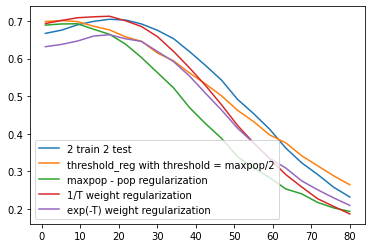

In [168]:
ratios = np.linspace(1,80,20)
c10_accuracies = [0.6668, 0.6753, 0.6895, 0.6986, 0.7043, 0.7023, 0.6918, 0.6748, 0.6527, 0.6182, 0.5813, 0.5423, 0.4911, 0.4535, 0.4120, 0.3623, 0.3227, 0.2917, 0.2578, 0.2321]
threshold_reg = [0.6984, 0.7008, 0.6980, 0.6859, 0.6761, 0.6576, 0.6455, 0.6143, 0.5939, 0.5615, 0.5322, 0.5007, 0.4622, 0.4322, 0.3969, 0.3761, 0.3416, 0.3148, 0.2881, 0.2646]
pop_reg = [0.6888, 0.6918, 0.6923, 0.6779, 0.6643, 0.6382, 0.6024, 0.5622, 0.5220, 0.4694, 0.4268, 0.3877, 0.3391, 0.3088, 0.2835, 0.2535, 0.2404, 0.2175, 0.2030, 0.1937];
#inverse_threshold_weighted_reg = [0.6908, 0.6936, 0.6894, 0.6781, 0.6650, 0.6414, 0.6152, 0.5820, 0.5482, 0.5102, 0.4762, 0.4335, 0.3929, 0.3605, 0.3390, 0.3023, 0.2813, 0.2569, 0.2387, 0.2247]
inverse_threshold_weighted_reg = [0.6929, 0.7010, 0.7083, 0.7108, 0.7123, 0.7003, 0.6850, 0.6579, 0.6188, 0.5749, 0.5279, 0.4767, 0.4219, 0.3758, 0.3336, 0.2918, 0.2586, 0.2273, 0.2069, 0.1871]
#exp_threshold_weighted_reg = [0.6868, 0.6864, 0.6814, 0.6657, 0.6530, 0.6230, 0.5959, 0.5540, 0.5046, 0.4592, 0.4086, 0.3646, 0.3231, 0.2927, 0.2644, 0.2364, 0.2177, 0.2048, 0.1938, 0.1832]
exp_threshold_weighted_reg = [0.6314, 0.6374, 0.6464, 0.6595, 0.6632, 0.6525, 0.6454, 0.6185, 0.5917, 0.5533, 0.5074, 0.4629, 0.4145, 0.3754, 0.3350, 0.3092, 0.2749, 0.2511, 0.2296, 0.2098]
plt.plot(ratios,c10_accuracies,label='2 train 2 test')
plt.plot(ratios,threshold_reg, label='threshold_reg with threshold = maxpop/2')
plt.plot(ratios,pop_reg, label='maxpop - pop regularization')
plt.plot(ratios,inverse_threshold_weighted_reg, label='1/T weight regularization')
plt.plot(ratios,exp_threshold_weighted_reg, label='exp(-T) weight regularization')
plt.legend()

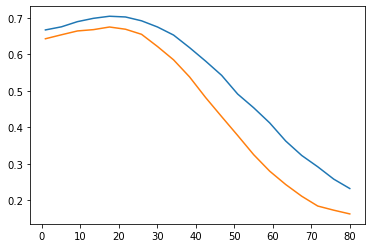

In [22]:
accuracies1 = [0.6668, 0.6753, 0.6895, 0.6986, 0.7043, 0.7023, 0.6918, 0.6748, 0.6527, 0.6182, 0.5813, 0.5423, 0.4911, 0.4535, 0.4120, 0.3623, 0.3227, 0.2917, 0.2578, 0.2321]
accuracies2 = [0.6426, 0.6535, 0.6640, 0.6676, 0.6748, 0.6687, 0.6548, 0.6212, 0.5848, 0.5379, 0.4815, 0.4292, 0.3776, 0.3249, 0.2797, 0.2431, 0.2110, 0.1841, 0.1727, 0.1625]
plt.plot(ratios,accuracies1)
plt.plot(ratios,accuracies2)

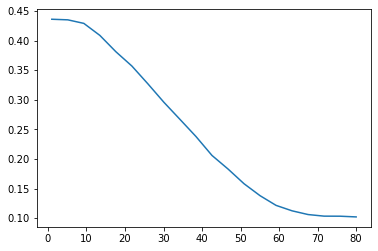

In [148]:
uniform=[0.4361, 0.4351, 0.4291, 0.4088, 0.3812, 0.3570, 0.3269, 0.2957, 0.2669, 0.2379, 0.2059, 0.1830, 0.1581, 0.1379, 0.1215, 0.1123, 0.1060, 0.1033, 0.1032, 0.1020]




plt.plot(ratios,uniform,label='uniform with \lambda = 10^-4, b = 32')


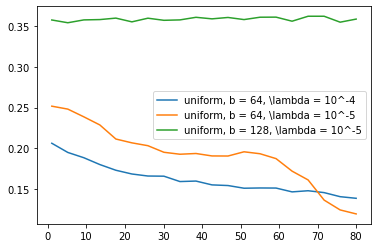

In [154]:
ratios = np.linspace(1,80,20)

uniform_b64_lambda10_4 = [0.2062, 0.1949, 0.1884, 0.1800, 0.1730, 0.1684, 0.1659, 0.1657, 0.1591, 0.1597, 0.1550, 0.1542, 0.1509, 0.1512, 0.1511, 0.1464, 0.1478, 0.1455, 0.1405, 0.1385]
uniform_b64_lambda10_5 = [0.2518, 0.2482, 0.2387, 0.2287, 0.2114, 0.2067, 0.2032, 0.1951, 0.1927, 0.1936, 0.1906, 0.1905, 0.1957, 0.1933, 0.1873, 0.1719, 0.1611, 0.1363, 0.1242, 0.1193]
uniform_b128_lambda10_5 = [0.3578, 0.3544, 0.3579, 0.3583, 0.3601, 0.3555, 0.3600, 0.3574, 0.3579, 0.3611, 0.3592, 0.3609, 0.3583, 0.3612, 0.3613, 0.3563, 0.3624, 0.3624, 0.3551, 0.3589]

plt.plot(ratios, uniform_b64_lambda10_4, label='uniform, b = 64, \lambda = 10^-4')
plt.plot(ratios, uniform_b64_lambda10_5, label='uniform, b = 64, \lambda = 10^-5')
plt.plot(ratios, uniform_b128_lambda10_5, label='uniform, b = 128, \lambda = 10^-5')
plt.legend()

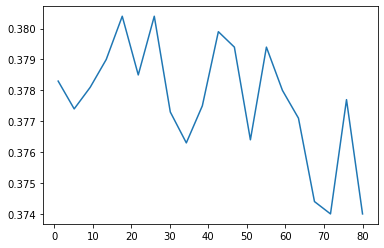

In [150]:
exponential_lambda10_3 = [0.3783, 0.3774, 0.3781, 0.3790, 0.3804, 0.3785, 0.3804, 0.3773, 0.3763, 0.3775, 0.3799, 0.3794, 0.3764, 0.3794, 0.3780, 0.3771, 0.3744, 0.3740, 0.3777, 0.3740]

plt.plot(ratios, exponential_lambda10_3, label='exponential, \lambda = 10^-3, \alpha = 1')

In [147]:
inverse_lambda10_3 = [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1001, 0.1001, 0.1000, 0.0996, 0.0997, 0.1002, 0.0999]
inverse_lambda10_4 = [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000]
inverse_lambda10_5 = [0.1066, 0.1066, 0.1059, 0.1067, 0.1068, 0.1063, 0.1067, 0.1063, 0.1052, 0.1049, 0.1010,0.1028, 0.1018, 0.1016, 0.1011, 0.1021, 0.1021, 0.1009, 0.1019, 0.1011]

In [ ]:
#b(T)
#b(lambda, beta, T, max_pop)

In [ ]:
lambda10_3_alpha_32 = [0.4960, 0.4919, 0.4939, 0.4950, 0.4947, 0.4904, 0.4935, 0.4932, 0.4911, 0.4900, 0.4890, 0.4918, 0.4978, 0.4925, 0.4909, 0.4934, 0.4886, 0.4923, 0.4946, 0.4932]
lambda10_4_alpha_32 = [0.1070, 0.1058, 0.1067, 0.1061, 0.1055, 0.1064, 0.1061, 0.1067, 0.1069, 0.1059, 0.1057, 0.1053, 0.1058, 0.1071, 0.1064, 0.1075, 0.1068, 0.1058, 0.1070, 0.1062]
lambda10_6_alpha_32 = [0.1823, 0.1823, 0.1820, 0.1810, 0.1816, 0.1834, 0.1811, 0.1810, 0.1797, 0.1785, 0.1826, 0.1811, 0.1811, 0.1829, 0.1829, 0.1826, 0.1808, 0.1815, 0.1784, 0.1784]
lambda10_2_alpha_32 = [0.1724, 0.1695, 0.1725, 0.1698, 0.1716, 0.1698, 0.1694, 0.1680, 0.1717, 0.1714, 0.1705, 0.1716, 0.1686, 0.1671, 0.1697, 0.1691, 0.1707, 0.1712, 0.1695, 0.1694]
lambda10_3_alpha_64 = [0.6390, 0.6359, 0.6360, 0.6356, 0.6390, 0.6403, 0.6374, 0.6372, 0.6380, 0.6351, 0.6356, 0.6371, 0.6413, 0.6360, 0.6394, 0.6395, 0.6426, 0.6363, 0.6355, 0.6398]
plt.plot()

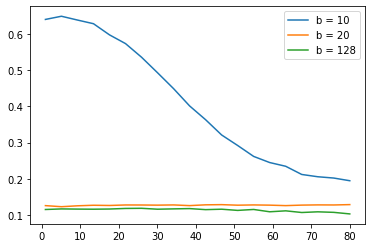

In [61]:
ratios = np.linspace(1,80,20)

b_10 = [0.6398, 0.6486, 0.6381, 0.6280, 0.5972, 0.5731, 0.5355, 0.4926, 0.4488, 0.4011, 0.3630, 0.3209, 0.2919, 0.2617, 0.2448, 0.2345, 0.2119, 0.2056, 0.2020, 0.1946]
b_20 = [0.1259, 0.1229, 0.1254, 0.1269, 0.1263, 0.1277, 0.1276, 0.1272, 0.1278, 0.1259, 0.1281, 0.1286, 0.1271, 0.1278, 0.1272, 0.1259, 0.1273, 0.1279, 0.1277, 0.1287]
b_128 = [0.1152, 0.1168, 0.1163, 0.1160, 0.1165, 0.1181, 0.1185, 0.1160, 0.1169, 0.1177, 0.1148, 0.1160, 0.1127, 0.1153, 0.1089, 0.1115, 0.1069, 0.1088, 0.1073, 0.1030]

plt.plot(ratios, b_10, label='b = 10')
plt.plot(ratios, b_20, label='b = 20')
plt.plot(ratios, b_128, label='b = 128')

plt.legend()

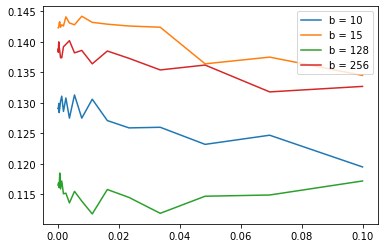

In [70]:
b_10 = [0.1291, 0.1290, 0.1293, 0.1299, 0.1284, 0.1291, 0.1303, 0.1311, 0.1286, 0.1308, 0.1275, 0.1313, 0.1275, 0.1306, 0.1271, 0.1259, 0.1260, 0.1232, 0.1247, 0.1195]
b_128 = [0.1165, 0.1165, 0.1169, 0.1167, 0.1161, 0.1185, 0.1159, 0.1172, 0.1151, 0.1152, 0.1136, 0.1155, 0.1139, 0.1118, 0.1158, 0.1145, 0.1119, 0.1147, 0.1149, 0.1172]
b_15 = [0.1423, 0.1423, 0.1423, 0.1424, 0.1431, 0.1433, 0.1424, 0.1428, 0.1426, 0.1441, 0.1431, 0.1428, 0.1442, 0.1432, 0.1429, 0.1426, 0.1424, 0.1364, 0.1375, 0.1345]
b_256 = [0.1388, 0.1383, 0.1391, 0.1400, 0.1392, 0.1385, 0.1374, 0.1374, 0.1392, 0.1396, 0.1402, 0.1382, 0.1386, 0.1364, 0.1385, 0.1373, 0.1354, 0.1362, 0.1318, 0.1327]

plt.plot(probs, b_10, label="b = 10")
plt.plot(probs, b_15, label="b = 15")
plt.plot(probs, b_128, label="b = 128")
plt.plot(probs, b_256, label="b = 256")
plt.legend()


Courbariaux

In [67]:
# clipping constraint
class ClipConstraint(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return tf.clip_by_value(w, -1.0, 1.0)

# batchnorm parameters
batch_size = 100
alpha = 0.1
epsilon = 1e-4

# sign activation
def sign(x):
    return tf.math.sign(x)


# model definition
model = Sequential()


In [ ]:
def scheduler(epoch, lr):
    return 0.003 * tf.math.pow(0.5,tf.math.floor(epoch/10))

schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)